In [1]:
!pip install covid19-supermarket-abm

In [12]:
from covid19_supermarket_abm.utils.load_example_data import load_example_store_graph
from covid19_supermarket_abm.utils.create_synthetic_baskets import get_all_shortest_path_dicts
from covid19_supermarket_abm.path_generators import get_path_generator
from covid19_supermarket_abm.simulator import simulate_several_days
from covid19_supermarket_abm.simulator import simulate_one_day
import networkx as nx

In [ ]:
# Set parameters
config = {'arrival_rate': 2.55,  # Poisson rate at which customers arrive
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 14,  # store opening hours
           'infection_proportion': 0.0011,  # proportion of customers that are infectious
         }

# Load store network data
G = load_example_store_graph()

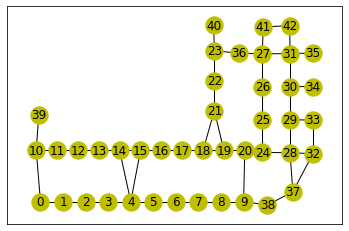

In [13]:
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G, pos=pos, node_color='y')

In [ ]:
# Create a path generator which feeds our model with customer paths
entrance_nodes = [39, 40, 41]
till_nodes = [33, 34, 35]
exit_nodes = [42]
item_nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
              19, 20, 21, 22, 23,24, 25, 26, 27, 28, 29, 30, 31, 32, 36, 37, 38]
mu = 0.07
sigma = 0.76
shortest_path_dict = get_all_shortest_path_dicts(G)

synthetic_path_generator_args = [mu, sigma, entrance_nodes, till_nodes, exit_nodes, item_nodes, shortest_path_dict]
path_generator_function, path_generator_args = get_path_generator(path_generation='synthetic',
                                                           synthetic_path_generator_args=synthetic_path_generator_args)

In [16]:
# Simulate several days and store results in results
results = simulate_several_days(config, G, path_generator_function, path_generator_args, num_iterations=50)

100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


In [18]:
results[0]

,num_cust,num_S,num_I,total_exposure_time,num_cust_w_contact,mean_num_cust_in_store,max_num_cust_in_store,num_contacts,mean_shopping_time,num_waiting_people,mean_waiting_time,store_open_length,total_time_crowded,exposure_times
0,2123,2118,5,10.651427,49,14.423529,26,110,5.823758,0,0,840,30.647713,"[0.32051547860720575, 0.13071959689578705, 0.2..."
1,2014,2009,5,10.234945,46,13.825581,22,112,5.812626,0,0,850,26.535253,"[0.3444256360380109, 0.022173271510524728, 0.8..."
2,2146,2144,2,2.944088,19,14.500000,26,40,5.821906,0,0,850,35.170469,"[0.031405186836224175, 0.10628137845590402, 0...."
3,2085,2081,4,6.453474,31,13.717647,22,69,5.687418,0,0,840,27.022894,"[0.4999742075071367, 0.2026860548547802, 0.080..."
4,2081,2081,0,0.000000,0,14.279070,28,0,5.773062,0,0,850,30.550837,[]
5,2176,2175,1,2.053587,12,14.453488,27,21,5.740954,0,0,850,33.923452,"[0.027331540087061512, 0.2617497037600742, 0.3..."
6,2107,2106,1,3.375155,10,15.176471,27,25,5.850969,0,0,840,40.368767,"[0.012588426934030394, 0.7320210253681942, 0.2..."
7,2127,2125,2,1.983150,12,14.023256,23,23,5.742734,0,0,850,31.334567,"[0.14960996402379578, 0.222134170275325, 0.545..."
8,2083,2082,1,0.825089,4,14.325581,25,7,5.793508,0,0,850,30.924184,"[0.6083668780791704, 0.024031411525577084, 0.0..."
9,2130,2126,4,7.295650,37,14.364706,25,81,5.847073,0,0,840,36.019280,"[0.839607293320455, 0.42191670159763817, 0.022..."
